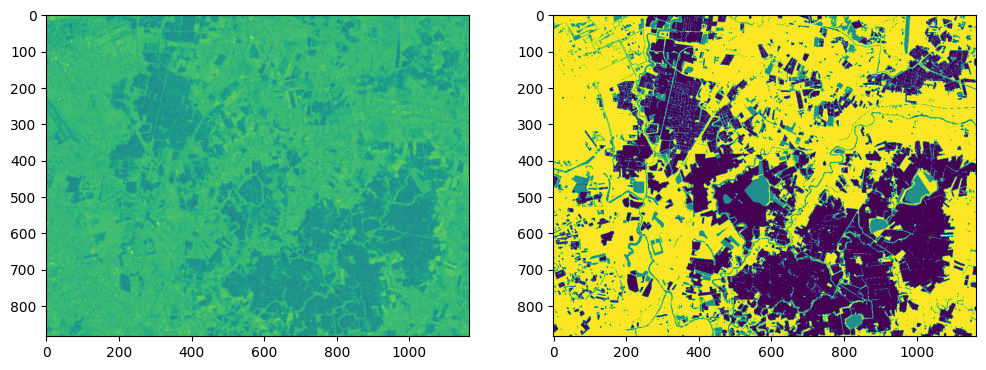

In [15]:
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt

img= Image.open("Large_Image.tif")
img = np.array(img)
mask = Image.open("LargeMask.tif")
mask = np.array(mask)

plt.figure(figsize = (12,8))
plt.subplot(121)
plt.imshow(img)

plt.subplot(122)
plt.imshow(mask)

In [16]:
matrix= np.array(img)

# print(matrix)
print(np.min(matrix))
print(np.max(matrix))

def min_max_normalization(matrix):
    min_val = np.min(matrix)
    max_val = np.max(matrix)
    # Normalize each value in the matrix using the min-max formula
    normalized_matrix = ((matrix - min_val) / (max_val - min_val))*255

    return normalized_matrix

image1=min_max_normalization(matrix)
image1
img_norm = Image.fromarray(image1)
img_norm = img_norm.save("img_norm.tif")

-62.581715
17.933926


## Masks

In [17]:
labels1, counts1 = np.unique(mask, return_counts=True)

result = np.column_stack((labels1, counts1))
print("flood labels are", labels1[0], " and the counts are: ", counts1[0])
print("non flood labels are", labels1[1], " and the counts are: ", counts1[1])
print("Permanent Water Labels are", labels1[2], " and the counts are ", counts1[2])

flood labels are 1.0  and the counts are:  351148
non flood labels are 2.0  and the counts are:  63142
Permanent Water Labels are 3.0  and the counts are  614686


## Dont Run below code

In [18]:
from PIL import Image
import os
import random
from sklearn.model_selection import train_test_split
import shutil

def cut_image_into_patches(image_path, mask_path, patch_size, stride, output_folder):
    # Open the large image and the corresponding mask
    image = Image.open(image_path)
    mask = Image.open(mask_path)

    # Get the dimensions of the large image and mask
    img_width, img_height = image.size

    # List to store the image and mask patch filenames
    patch_filenames = []

    # Iterate over the large image to extract patches with the specified stride
    for x in range(0, img_width - patch_size + 1, stride):
        for y in range(0, img_height - patch_size + 1, stride):
            # Define the coordinates of the patch
            left = x
            upper = y
            right = x + patch_size
            lower = y + patch_size

            # Crop the patch from the large image and the corresponding mask
            patch_img = image.crop((left, upper, right, lower))
            patch_mask = mask.crop((left, upper, right, lower))

            # Save the patch as a separate image in the output folder
            img_filename = f"image_{x}_{y}.tif"
            mask_filename = f"mask_{x}_{y}.tif"
            patch_img.save(os.path.join(output_folder, "images", img_filename))
            patch_mask.save(os.path.join(output_folder, "masks", mask_filename))

            # Add the patch filenames to the list
            patch_filenames.append((img_filename, mask_filename))

    return patch_filenames

# Specify the paths and parameters for cutting the image into patches
large_image_path = "img_norm.tif"
large_mask_path = "LargeMask.tif"
patch_size = 256
stride = 32
output_folder = "Output Data"

# Create the output folders for images and masks if they don't exist
os.makedirs(os.path.join(output_folder, "images"), exist_ok=True)
os.makedirs(os.path.join(output_folder, "masks"), exist_ok=True)

# Call the function to cut the image into patches and save them,
# and get the list of patch filenames
patch_filenames = cut_image_into_patches(large_image_path, large_mask_path, patch_size, stride, output_folder)

# Split the patch filenames into training and testing sets
train_ratio = 0.8  # 80% training data, 20% testing data
train_files, test_files = train_test_split(patch_filenames, train_size=train_ratio, random_state=42)

# Define the paths for the training and testing folders
train_folder = "Output Data\Train"
test_folder = "Output Data\Test"

# Create the training and testing folders if they don't exist
os.makedirs(os.path.join(train_folder, "images"), exist_ok=True)
os.makedirs(os.path.join(train_folder, "masks"), exist_ok=True)
os.makedirs(os.path.join(test_folder, "images"), exist_ok=True)
os.makedirs(os.path.join(test_folder, "masks"), exist_ok=True)

# Copy the training files to the training folders
for img_filename, mask_filename in train_files:
    shutil.copy(os.path.join(output_folder, "images", img_filename), os.path.join(train_folder, "images", img_filename))
    shutil.copy(os.path.join(output_folder, "masks", mask_filename), os.path.join(train_folder, "masks", mask_filename))

# Copy the testing files to the testing folders
for img_filename, mask_filename in test_files:
    shutil.copy(os.path.join(output_folder, "images", img_filename), os.path.join(test_folder, "images", img_filename))
    shutil.copy(os.path.join(output_folder, "masks", mask_filename), os.path.join(test_folder, "masks", mask_filename))


## Dont Run Above code again


In [3]:
from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [4]:
import os
import numpy as np
import tifffile as tiff
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate

# Step 1: Organize your data in separate folders for training and testing.

# Step 2: Load and preprocess your data.
def load_image(filename):
    image = tiff.imread(filename).astype(np.float32) / 255.0  # Normalize to [0, 1]
    return image

def load_mask(filename):
    mask = tiff.imread(filename).astype(np.float32) / 255.0  # Normalize to [0, 1]
    return mask

# Load and preprocess training images and masks
train_image_folder = "Output Data\Train\images"
train_mask_folder = "Output Data\Train\masks"

train_image_files = os.listdir(train_image_folder)
train_mask_files = os.listdir(train_mask_folder)

train_images = [load_image(os.path.join(train_image_folder, f)) for f in train_image_files]
train_masks = [load_mask(os.path.join(train_mask_folder, f)) for f in train_mask_files]

# Add channel dimension to training images
train_images = [np.expand_dims(image, axis=-1) for image in train_images]


# Load and preprocess testing images and masks
test_image_folder = "Output Data\Test\images"
test_mask_folder = "Output Data\Test\masks"

test_image_files = os.listdir(test_image_folder)
test_mask_files = os.listdir(test_mask_folder)

test_images = [load_image(os.path.join(test_image_folder, f)) for f in test_image_files]
test_masks = [load_mask(os.path.join(test_mask_folder, f)) for f in test_mask_files]

# Add channel dimension to testing images
test_images = [np.expand_dims(image, axis=-1) for image in test_images]


In [5]:
print(len(test_image_files))
print(len( test_masks))
print(len(train_images))
print(len(train_masks))

116
116
464
464


### Step 3: the U-Net model.

In [6]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
################################################################
def multi_unet_model(n_classes=3, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    #model.summary()
    
    return model

In [7]:
import segmentation_models as sm

import os
os.environ["SM_FRAMEWORK"] = "tf.keras"



from tensorflow import keras
import segmentation_models as sm

# Define input shape (adjust according to your requirements)
input_shape = (256, 256, 1)

# Load the default U-Net model with ResNet18 backbone and imagenet weights
model = sm.Unet('resnet18', input_shape=input_shape, encoder_weights='imagenet')

# Compile the model (customize the optimizer and loss function as needed)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
print(model.summary())

AttributeError: module 'keras.utils' has no attribute 'generic_utils'